# BDMLtools构建梯度提升模型  <font size=3 >by 曾珂</font>

In [1]:
import pandas as pd
import numpy as np
import BDMLtools as bm
import lightgbm
import xgboost
import sklearn

In [2]:
print("pandas v"+str(pd.__version__))
print("numpy v"+str(np.__version__))
print("BDMLtools v"+str(bm.__version__))
print("sklearn v"+str(sklearn.__version__))
print("lightgbm v"+str(lightgbm.__version__))
print("xgboost v"+str(xgboost.__version__))

pandas v1.3.3
numpy v1.20.3
BDMLtools v0.2.1
sklearn v1.0.2
lightgbm v3.3.1
xgboost v1.5.1


## 1 数据说明

+ 此数据为外国某消费金融公司的某个人消费类贷款产品数据,客群大多拥有信用记录,要求在贷款准入节点构建评分卡评估客群信用风险,为贷中审批,授信定价提供参考。

+ 原始数据包括客户的申请信息,外部数据,征信信息,历史申请信息(若有),历史贷款表现(若有)五类信息,分散于不同的表中,这里已经进行了特征构建与宽表构建

+ 原始数据共20万样本,5000多个特征,这里为简化选择原数据中的122个特征与随机3万的样本演示

+ 特征含义见下:


```
1.申请及外部数据字段
 ID':订单编号
 TARGET:目标变量
 GENDER':性别(F,M)
 Age:年龄
 FLAG_OWN_CAR:是否有车
 OWN_CAR_AGE:拥有车时长
 HOUSING_TYPE:住房类型
 FLAG_OWN_REALTY:是否有房产
 NUM_CHILDREN':子女个数
 EDULEVEL:教育水平
 MARRIAGE':婚姻状况
 DAYS_EMPLOYED:工作时长天
 DAYS_LAST_PHONE_CHANGE':以往申请记录中联系方式变更距今时长天
 DAYS_ID_PUBLISH:以往申请记录中变更申请的身份材料时长天
 CITY_RATING:居住城市综合水平评级
 score1:外部信用评分1
 score2:外部信用评分2
 score3:外部信用评分3
2.征信记录
 Bureau_Var102:近18月最大授信金额_在贷
 Bureau_Var1033:最大授信使用率_所有
 Bureau_Var1036:近24月最大授信使用率_所有
 Bureau_Var1044:近24月平均授信使用率_所有
 Bureau_Var1048:近24月平均授信使用率_在贷
 Bureau_Var1060:近24月平均授信使用率_所有_信用卡
 Bureau_Var1061:平均授信使用率_在贷_信用卡
 Bureau_Var1068:近24月最大授信使用率_所有_贷款
 Bureau_Var1069:最大授信使用率_在贷_贷款
 Bureau_Var1072:近24月最大授信使用率_在贷_贷款
 Bureau_Var1075:近12月平均授信使用率_所有_贷款
 Bureau_Var1089:平均授信使用率_所有_消费金融
 Bureau_Var109:近15月平均授信金额_所有
 Bureau_Var1096:近24月平均授信使用率_在贷_消费金融
 Bureau_Var1098:180天以内贷款笔数_所有
 Bureau_Var112:平均授信金额_所有
 Bureau_Var1120:征信到期日前360天贷款笔数_在贷_贷款
 Bureau_Var1123:征信到期日前270天贷款笔数_所有_消费金融
 Bureau_Var1129:已结清征信90天贷款笔数_所有
 Bureau_Var1132:已结清征信360天贷款笔数_所有
 Bureau_Var1149:已结清征信90天贷款笔数_在贷_贷款
 Bureau_Var1152:已结清征信360天贷款笔数_在贷_贷款
 Bureau_Var1153:已结清征信90天贷款笔数_所有_消费金融
 Bureau_Var1157:已结清征信90天贷款笔数_在贷_消费金融
 Bureau_Var1159:已结清征信270天贷款笔数_在贷_消费金融
 Bureau_Var116:近1年平均授信金额_在贷
 Bureau_Var1160:已结清征信360天贷款笔数_在贷_消费金融
 Bureau_Var117:近15月平均授信金额_在贷
 Bureau_Var120:平均授信金额_在贷
 Bureau_Var124:近1年授信金额标准差_所有
 Bureau_Var128:授信金额标准差_所有
 Bureau_Var136:平均授信金额标准差_在贷
 Bureau_Var140:近1年最大负债_所有
 Bureau_Var141:近15月最大负债_所有
 Bureau_Var142:近18月最大负债_所有
 Bureau_Var150:近18月最大负债_在贷
 Bureau_Var156:近1年总负债_所有
 Bureau_Var159:近2年总负债_所有
 Bureau_Var19:近6月客户贷款数_在贷
 Bureau_Var21:近15月客户贷款数_在贷
 Bureau_Var22:近18月客户贷款数_在贷
 Bureau_Var24:客户贷款数_在贷
 Bureau_Var248:最大历史逾期金额_所有_信用卡
 Bureau_Var272:贷款平均最大历史逾期金额_在贷_信用卡
 Bureau_Var304:最大授信金额_在贷_信用卡
 Bureau_Var311:近2年平均授信金额_所有_信用卡
 Bureau_Var312:平均授信金额_所有_信用卡
 Bureau_Var317:近15月平均授信金额_在贷_信用卡
 Bureau_Var320:平均授信金额_在贷_信用卡
 Bureau_Var328:授信金额标准差_所有_信用卡
 Bureau_Var342:近18月最大负债_所有_信用卡
 Bureau_Var343:近2年最大负债_所有_信用卡
 Bureau_Var359:近2年总负债_所有_信用卡
 Bureau_Var368:总负债_在贷_信用卡
 Bureau_Var416:客户贷款数_结清_贷款
 Bureau_Var448:最大历史逾期金额_所有_贷款
 Bureau_Var48:最大历史逾期金额_所有
 Bureau_Var492:近1年最大授信金额_所有_贷款
 Bureau_Var494:近18月最大授信金额_所有_贷款
 Bureau_Var496:最大授信金额_所有_贷款
 Bureau_Var499:近6月最大授信金额_在贷_贷款
 Bureau_Var5:近15月客户贷款数_所有
 Bureau_Var507:近6月平均授信金额_所有_贷款
 Bureau_Var515:近6月平均授信金额_在贷_贷款
 Bureau_Var516:近1年平均授信金额_在贷_贷款
 Bureau_Var526:近18月授信金额标准差_所有_贷款
 Bureau_Var536:平均授信金额标准差_在贷_贷款
 Bureau_Var558:近18月总负债_所有_贷款
 Bureau_Var56:贷款平均最大历史逾期金额_所有
 Bureau_Var560:总负债_所有_贷款
 Bureau_Var568:总负债_在贷_贷款
 Bureau_Var616:客户贷款数_结清_消费金融
 Bureau_Var664:最大历史逾期金额_在贷_消费金融
 Bureau_Var680:贷款展期总次数_在贷_消费金融
 Bureau_Var688:贷款展期总次数_所有_消费金融
 Bureau_Var694:近18月最大授信金额_所有_消费金融
 Bureau_Var700:近1年最大授信金额_在贷_消费金融
 Bureau_Var701:近15月最大授信金额_在贷_消费金融
 Bureau_Var704:最大授信金额_在贷_消费金融
 Bureau_Var707:近6月平均授信金额_所有_消费金融
 Bureau_Var708:近1年平均授信金额_所有_消费金融
 Bureau_Var709:近15月平均授信金额_所有_消费金融
 Bureau_Var716:近1年平均授信金额_在贷_消费金融
 Bureau_Var751:近2年最大负债_在贷_消费金融
 Bureau_Var755:近6月总负债_所有_消费金融
 Bureau_Var765:近15月总负债_在贷_消费金融
 Bureau_Var806:近15月最大信用卡额度_所有_信用卡
 Bureau_Var807:近18月最大信用卡额度_所有_信用卡
 Bureau_Var94:近18月最大授信金额_所有
 Bureau_Var96:最大授信金额_所有  
3.以往的逾期/还款类字段
 IP_Var24:近24月贷款最大逾期天数
 IP_Var30:近24月逾期期数占所有期数比例
 IP_Var31:提前还款期数占所有期数比例
 IP_Var36:近24月提前还款期数占所有期数比例
4.以往的申请记录
 Previous_Var22:近24月贷款申请次数
 Previous_Var289:贷款申请平均金额_通过_CashLoan
 Previous_Var49:贷款申请平均金额_通过
 Previous_Var53:近12月贷款申请平均金额_通过
 Previous_Var536:近24月贷款申请平均金额_通过_ConsumerLoan
 Previous_Var545:贷款申请总金额_通过_ConsumerLoan
 Previous_Var56:近24月贷款申请平均金额_通过
 Previous_Var63:近18月贷款申请最大金额_通过
 Previous_Var64:近24月贷款申请最大金额_通过
```

## 2 数据处理

以Pipline工作流的形式进行数据处理,各个函数作用请见其文档

    Step 1.dtStandardization:实体一致性转换
    Step 2.dtypeAllocator:列类型分配转换
    Step 3.nanTransformer:缺失值处理
    Step 4.outliersTransformer:异常值处理

In [3]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(
    
    [('1.dtStandardization',bm.dtStandardization(id_col=['ID'],drop_dup=True)), 
                 
     ('2.dtypeAllocator', bm.dtypeAllocator(dtypes_dict={})),
                 
     ('3.nanTransformer',bm.nanTransformer(method=('constant','constant'),
                                         missing_values=[np.nan,np.inf,-np.inf,'nan','','special','missing'],
                                         fill_value=(np.nan,'missing'),
                                         indicator=False)),
    
     ('4.outliersTransformer', bm.outliersTransformer())
     
    ])                           

In [4]:
dat=pipe.fit_transform(pd.read_csv('Data/creditdata_small.csv'))

## 3 数据分区

本案例只考虑in-sample分区

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test=train_test_split(dat.drop('TARGET',axis=1),
                                                  dat['TARGET'],
                                                  test_size=0.33, 
                                                  random_state=1223,stratify=dat['TARGET'])

## 3 预拟合模型

bm.prefitModel为预拟合模型，提供了在不进行任何特征筛选的前提下使用全量数据建模以预估模型效果的功能

若后续特征筛选过程合理则模型表现不会差距过多，甚至会比预拟合模型好

+ 此步骤并非必须
+ 默认使用lightgbm作为训练算法
+ 更多详请请见帮助文档

In [7]:
p_model=bm.prefitModel().fit(X_train,y_train)

+ 模型表现

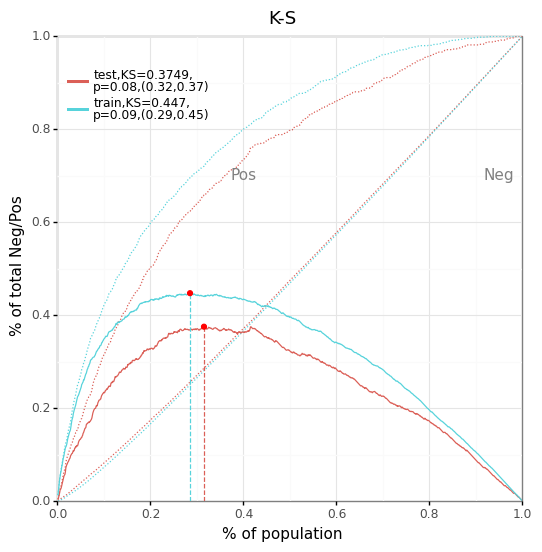

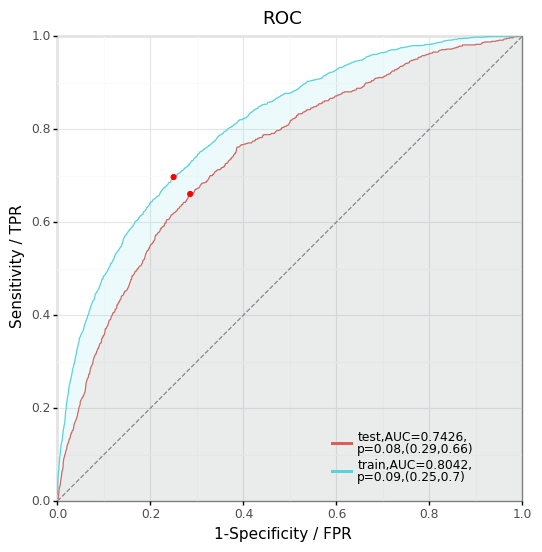

{'ks': <ggplot: (8793744123642)>, 'roc': <ggplot: (8793744128940)>}

In [8]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(p_model.predict_proba(X_train),index=X_train.index),
    pd.Series(p_model.predict_proba(X_test),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) #可以看到test数据上ks与auc的情况,此结果可作为模型结果的参考值

## 5 特征筛选

### 5.1 预筛

预筛:当特征数量过多时，快速筛选掉无用特征

bm.preSelector提供了类似的功能,能够快速过滤掉那些**非常不重要的特征**

    Step 1.缺失值(所有):缺失率高于用户定义值的列将被筛除(参数na_pct控制)
    Step 2.唯一值(所有):唯一值占比高于用户定义值列将被筛除(参数unique_pct控制)
    Step 3.方差(数值特征):方差低于用户定义值列的列将被筛除(参数variance控制)
    Step 4.卡方独立性检验p值(字符)/方差分析p值(数值):p值大于用户定义值的列将被剔除(参数chif_pvalue控制)
    Step 6.Lightgbm筛选(所有):split重要性低于用户定义值的列将被剔除(参数tree_imps、tree_size控制)
    Step 7.Iv值筛选(所有):等频30箱后iv值低于用户定义值的列将被剔除(参数iv_limit控制)
    
详见帮助文档

In [9]:
pre=bm.preSelector(
    na_pct=0.95, #缺失率高于na_pct的列将被筛除
    unique_pct=0.95,#唯一值占比高于unique_pct的列将被筛除
    variance=0,#方差低于variance的列(连续)将被筛除
    chif_pvalue=0.05,#大于chif_pvalue的列将被剔除
    tree_imps=1,#split_gain小于等于tree_imps的列将被剔除
    tree_size=100,#LGBM树个数
    iv_limit=0.02 #iv小于等于iv_limit的特征将被踢出
).fit(X_train,y_train)

0.start__________________________________complete
1.filterbyNA_____________________________complete
2.filterbyUniquepct______________________complete
3.filterbyVariance_______________________complete
4.filterbyChi2Oneway_____________________complete
6.filterbyTrees__________________________complete
7.filterbyIV_____________________________complete
_____________________________________________Done
步骤0.orgin,保留的特征数:113
步骤1.filterbyNA,保留的特征数:108
步骤2.filterbyUnique,保留的特征数:108
步骤3.filterbyVariance,保留的特征数:108
步骤4.filterbyChi2Oneway,保留的特征数:106
步骤6.filterbyTrees,保留的特征数:103
步骤7.filterbyIV,保留的特征数:98


In [10]:
X_train_1=pre.transform(X_train) #数据经transform后过滤掉了无用特征
X_test_1=pre.transform(X_test) 

案例数据中的特征的预测能力都比较强，预筛选过程中有少量特征被筛选掉

### 5.2 递归式特征消除

基于交叉验证的递归式特征消除(Recursive feature elimination with cross-validation)是一种机器学习特征筛选方法，其利用基模型(必须拥有属性_coef或_feature_importance)的特征重要性指标进行特征筛选:

sklearn.feature_selection.RFE筛选过程:

    1.指定基模型、保留的特征数量(n_features_to_select参数控制)
    2.拟合模型，输出特征权重
    3.将特征权重较小的一部分特征(step参数控制)消除
    4.重复步骤2,3直到保留的特征数量=n_features_to_select

sklearn.feature_selection.RFECV筛选过程:

    1.指定基模型、最小保留的特征数量(min_features_to_select),交叉验证参数(cv),模型评价指标(scoring),RFE步长(step)等
    2.按照交叉验证参数设定进行切分数据
    3.在不同的交叉验证数据上进行RFE(n_features_to_select,step...)拟合并记录每一步特征消除的在验证数据上评价指标(scoring),剩余特征数量,可选择并行
    4.对交叉验证数据的评价指标(scoring)进行平均，并选择最高指标下的剩余特征数量作为n_select,以max(n_select,min_features_to_select)作为特征筛选个数
    5.再进行RFE(n_features_to_select=max(n_select,min_features_to_select))拟合全量数据并得到具体筛选的特征


这里笔者将LightGBM与RFECV进行了集成用于商业分析场景中机器学习项目的特征筛选(bm.LgbmRFECVSelector),

其中选择LightGBM作为基模型的理由:

+ 可处理缺失值,可处理分类特征,因此对原始数据无需过多的复杂处理
+ 算法运行效率高于同类模型,尤其在使用交叉验证时模型训练时间得以大大缩短
+ LightGBM支持计算特征重要性(split重要性或梯度gain重要性)

实践中可使用LgbmRFECVSelector进行预筛后的特征筛选

参考资料:
+ [Sklearn中RFE介绍](https://scikit-learn.org/stable/modules/feature_selection.html#rfe)
+ [Sklearn中RFE源码](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/feature_selection/_rfe.py)

In [11]:
rfe=bm.LgbmRFECVSelector(min_features_to_select=1,cv=5,repeats=1,random_state=111).fit(X_train_1,y_train)

In [12]:
X_train_2=rfe.transform(X_train_1)
X_test_2=rfe.transform(X_test_1)

### 5.3 序列式特征消除

序列式特征消除(Sequential Feature Selection)是一种机器学习特征筛选方法，其思想类似于统计学方法中的逐步回归

序列式特征消除过程

    1.指定基模型、序列法方向(direction),保留的特征数量(n_features_to_select),交叉验证参数(cv),模型评价指标(scoring)等
    2.根据序列法方向(direction)进行特征消除:
        + 'foreward':根据交叉验证数据上的模型评价指标(scoring)从候选特征中逐步得加入最优特征组成模型
        + 'backward':根据交叉验证数据上的模型评价指标(scoring)从候选特征中逐步得减少最差特征组成模型
    3.重复步骤2直到选择出的特征数量=n_features_to_select
    
这里笔者将LightGBM与SequentialFeatureSelector进行了集成用于商业分析场景中机器学习项目的特征筛选(bm.LgbmSeqSelector)

其中选择LightGBM作为基模型的理由:

+ 可处理缺失值,可处理分类特征,因此对原始数据无需过多的复杂处理
+ 算法运行效率高于同类模型,尤其在使用交叉验证时模型训练时间得以大大缩短
+ LightGBM支持计算特征重要性(split重要性或梯度gain重要性)


实践中可使用LgbmRFECVSelector进行预筛后的特征筛选

参考资料:
+ [Sklearn中SequentialFeatureSelector介绍](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection)
+ [Sklearn中SequentialFeatureSelector源码](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/feature_selection/_sequential.py)

这里假定我们需选择最多30个特征构建梯度提升模型

In [13]:
n_features_to_select=min(30,int(X_train_2.shape[1]/2)) 

direction='forward' if X_train_2.shape[1]/2>n_features_to_select else 'backward' 

print(direction,n_features_to_select)

forward 30


In [14]:
seq=bm.LgbmSeqSelector(direction=direction,
                       n_features_to_select=n_features_to_select,
                       scoring='ks',
                       cv=5,repeats=1).fit(X_train_2,y_train)

In [15]:
X_train_3=seq.transform(X_train_2)
X_test_3=seq.transform(X_test_2)

## 6 建模

### 6.1 超参数优化

超参数优化方法:
    
+ 经验超参数
+ [暴力网格搜索(GridSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
+ [随机网格搜索(RandomizedSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)
+ [减半网格搜索(HalvingGridSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving):注意目前sklearn的1.02版本中为实验算法
+ [随机减半网格搜索(HalvingRandomSearchCV)](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving):注意目前sklearn的1.02版本中为实验算法
+ [贝叶斯优化(BayesianOptimization)](https://github.com/fmfn/BayesianOptimization)

这里笔者对网格搜索、减半网格搜索、贝叶斯优化算法与LightGBM,Xgboost进行了集成,详见帮助文档

+ bm.BayesianXGBTuner:基于Xgboost的贝叶斯优化
+ bm.BayesianLgbmTuner:基于LightGBM的贝叶斯优化
+ bm.girdTuner:基于LightGB\Xgboost的暴力网格\随机网格优化
+ bm.hgirdTuner:基于LightGB\Xgboost的减半网格\随机减半网格优化

**案例仅以bm.BayesianLgbmTuner为例**

参数空间

In [16]:
para_space={
         'n_estimators':(300,300),
         'learning_rate':(0.05,0.2), 

         'max_depth':(2,4),
         'min_split_gain': (0,20),
         'min_sum_hessian_in_leaf': (0,20),
         
         'subsample':(0.5,1),
         'colsample_bytree' :(0.5,1),
         'reg_lambda':(0,10), 
         }

固定参数:贝叶斯优化中不支持字符型参数，这些参数可以以固定参数(fixed_params)的形式传递给模型

In [17]:
fixed_params={'boosting_type': 'goss', 
              'objective': 'binary'}

In [18]:
np.seterr('ignore')
lgbm=bm.BayesianLgbmTuner(para_space,fixed_params=fixed_params, #参数
                          n_iter=10,init_points=5, #贝叶斯搜索参数
                          scoring='ks', #评估函数
                          cv=5,repeats=1, #交叉验证参数
                          early_stopping_rounds=10,validation_fraction=0.1, #early_stopping参数
                          random_state=123, #设定随机数以复现模型
                          calibration=True #使用sklearn.calibration.CalibratedClassifierCV进行概率校准
                         ).fit(X_train_3,y_train)

|   iter    |  target   | colsam... | learni... | max_depth | min_sp... | min_su... | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
 Stopped after 300 iterations with val-ks = 0.374406
|  1        |  0.3744   |  0.8482   |  0.09292  |  2.454    |  11.03    |  14.39    |  300.0    |  9.808    |  0.8424   |
 Stopped after 300 iterations with val-ks = 0.373313
|  2        |  0.3733   |  0.7405   |  0.1088   |  2.686    |  14.58    |  8.771    |  300.0    |  3.98     |  0.869    |
 Stopped after 300 iterations with val-ks = 0.372896
|  3        |  0.3729   |  0.5912   |  0.07632  |  3.063    |  10.64    |  12.69    |  300.0    |  7.245    |  0.8055   |
 Stopped after 300 iterations with val-ks = 0.377266
|  4        |  0.3773   |  0.8612   |  0.09844  |  2.724    |  4.565    |  5.874    |  300.0    |  0.921    |  0.7169   |
 Stopped after 300 iterations with val-ks = 0.379743
|  

最优参数

In [19]:
lgbm.params_best

{'max_depth': 2,
 'n_estimators': 300,
 'colsample_bytree': 0.5989750340894475,
 'learning_rate': 0.1325168806112717,
 'min_split_gain': 7.127146673760805,
 'min_sum_hessian_in_leaf': 7.610446205925165,
 'reg_lambda': 9.996171626555082,
 'subsample': 0.9621554782145549,
 'best_iteration_': 78}

参数寻优数据

In [20]:
lgbm.cv_result

,colsample_bytree,learning_rate,max_depth,min_split_gain,min_sum_hessian_in_leaf,n_estimators,reg_lambda,subsample,val_ks,boosting_type,objective
0,0.545059,0.070820,2.012653,12.333920,14.677241,300.0,5.007154,0.590769,0.383906,goss,binary
1,0.715082,0.123626,3.732604,8.303029,14.906811,300.0,1.255616,0.702993,0.375962,goss,binary
2,0.501912,0.177478,2.121741,7.897924,8.226769,300.0,9.634720,0.623127,0.373037,goss,binary
3,0.715507,0.095414,2.872375,7.118931,7.703596,300.0,9.643246,0.673820,0.380649,goss,binary
4,0.787974,0.118388,3.214415,8.019171,15.283441,300.0,1.096387,0.512787,0.382131,goss,binary
5,0.819340,0.185404,2.656768,6.521781,7.428898,300.0,9.469852,0.751196,0.377732,goss,binary
6,0.641739,0.093633,2.042222,7.780109,6.962156,300.0,9.849207,0.565207,0.379941,goss,binary
7,0.598975,0.132517,2.399229,7.127147,7.610446,300.0,9.996172,0.962155,0.387116,goss,binary
8,0.829805,0.085534,2.105930,4.774687,9.513812,300.0,9.870499,0.910968,0.376752,goss,binary
9,0.653100,0.095338,3.267852,4.535191,6.535054,300.0,7.924551,0.561997,0.376419,goss,binary


可用于部署的模型(mlflow)

In [21]:
lgbm.model_refit

CalibratedClassifierCV(base_estimator=sLGBMClassifier(boosting_type='goss',
                                                      colsample_bytree=0.5989750340894475,
                                                      learning_rate=0.1325168806112717,
                                                      max_depth=2,
                                                      min_split_gain=7.127146673760805,
                                                      min_sum_hessian_in_leaf=7.610446205925165,
                                                      n_estimators=300,
                                                      objective='binary',
                                                      reg_lambda=9.996171626555082,
                                                      seed=123,
                                                      subsample=0.9621554782145549),
                       cv=5, n_jobs=-1)

### 6.2 模型评估

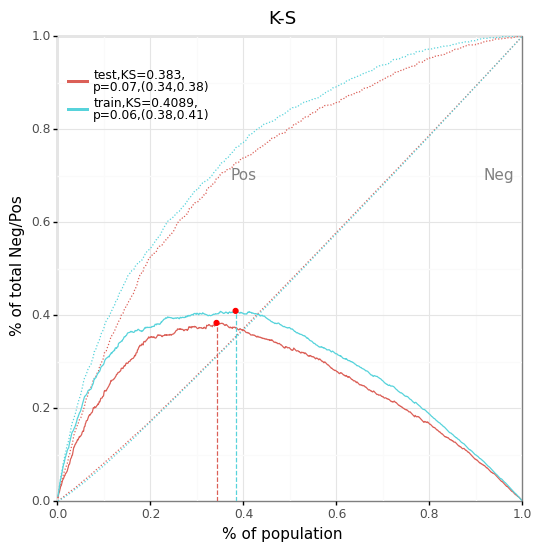

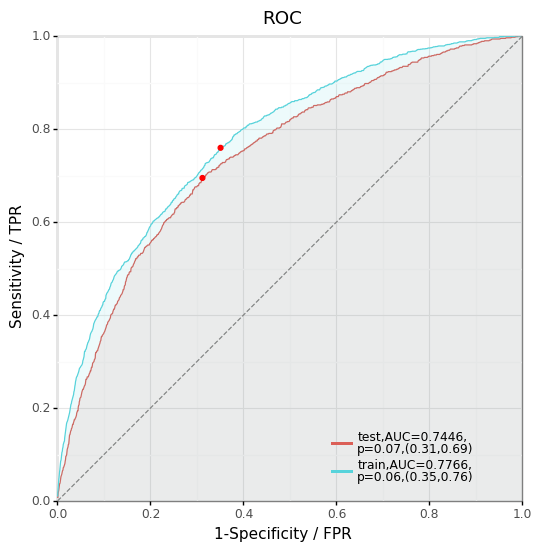

{'ks': <ggplot: (8793744809201)>, 'roc': <ggplot: (8793744807259)>}

In [22]:
y=pd.concat([
    y_train,
    y_test]
)

pred=pd.concat([
    pd.Series(lgbm.predict_proba(X_train_3),index=X_train.index),
    pd.Series(lgbm.predict_proba(X_test_3),index=X_test.index)]
)

group=pd.concat([
    pd.Series('train',index=X_train.index),
    pd.Series('test',index=X_test.index)]
)

bm.perfEval().plot(pred,y,group,figure_size=(6,6)) 